#### Setup: Importing the required libraries and reading the data

In [102]:
import pandas as pd
import numpy as np
from itertools import combinations
import html
import matplotlib.pyplot as plt
import joypy
import ast
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import re
import emoji
import html
import multiprocessing
from pathos.multiprocessing import ProcessingPool as Pool
from gensim import corpora, models
from gensim.utils import simple_preprocess
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import torch
from transformers import BertTokenizer, BertModel
import torch

In [103]:
TRAINING_DATA_PATH = "/scratch/jpatil/workspace/mini_project/training_data.csv"
TEST_DATA_PATH = "/scratch/jpatil/workspace/mini_project/test_data.csv"

In [78]:
def byte_string_decode(tweet):
    """
    Decodes a byte string representation of a tweet.

    This function takes a string representation of a byte string, evaluates it to 
    convert it into an actual byte string, and then decodes it using UTF-8 encoding.

    Args:
        tweet (str): A string representation of a byte string (e.g., "b'example'").

    Returns:
        str: The decoded string.
    """
    b_string = ast.literal_eval(tweet)
    return b_string.decode('utf-8')

In [104]:
training_df = pd.read_csv(TRAINING_DATA_PATH, encoding='utf-8')
df_test = pd.read_csv(TEST_DATA_PATH, encoding='utf-8')

training_df["full_text"] = training_df["full_text"].apply(byte_string_decode)
df_test["full_text"] = df_test["full_text"].apply(byte_string_decode)

In [80]:
training_df.head()

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,WATCH my speech on the @SenateFloor to learn more about the #PatientFreedomAct and what it means for West Virginia. https://t.co/MXV9dHZOTe,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,Boehner delays leadership races. Only speaker election this week. #rossformajoritywhip,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,"I'll be sharing #scarynumbers about #governmentspending for the rest of the month. Keep an eye out for the stats, here.",scarynumbers governmentspending,4,2014,0.513246,-0.224541
3,34,"#OTD in '64, LBJ took important step towards fulfilling promise of the Constitution by signing the Civil Rights Act. https://t.co/UmYmWV8p7A",OTD,14,2017,-0.241932,0.097843
4,23,"My bipartisan bill is a step toward protecting &amp; expanding affordable, reliable healthcare access as the pandemic continues. Telehealth is a vital part of that effort. Through expanded access to telehealth, we can reduce costs and improve health outcomes. #VA07 https://t.co/1gre1lOtgM",VA07,7,2020,-0.225722,0.329999


<br></br>

### Part I - Descriptive Analytics

#### Section A

##### Part a) 
Create a table that contains information on minimum, average, median, and maximum for the following: tweet length (#characters and #words) (text column), hashtag length (#characters and #words) (hashtags column) (Add your table to the report.) (4 points) (2 pointsfor graduate students)

In [39]:
col_stats_df = pd.DataFrame()

In [40]:
col_stats_df["tweet_word_length"] = training_df["full_text"].apply(lambda x : len(x.split())).describe()
col_stats_df["tweet_character_length"] = training_df["full_text"].apply(lambda x: len(x.replace('""', ""))).describe()

In [41]:
col_stats_df["hastag_word_length"] = training_df["hashtags"].apply(lambda x : len(x.split())).describe()
col_stats_df["hastag_character_length"] = training_df["hashtags"].apply(lambda x: len(x.replace('""', ""))).describe()

In [42]:
col_stats_df.drop(["count", "std", "25%", "75%"], axis=0, inplace=True)
col_stats_df.rename(index={"50%": "median"}, inplace=True)

In [43]:
col_stats_df

,tweet_word_length,tweet_character_length,hastag_word_length,hastag_character_length
mean,25.035591,173.823921,1.49198,14.536123
min,1.000000,4.000000,1.00000,1.000000
median,21.000000,143.000000,1.00000,12.000000
max,67.000000,531.000000,17.00000,184.000000


<br></br>

##### Part b) 
Find the top ten most commonly used hashtags (hashtags column). Then, create a bar chart which show the count values of these ten most commonly used hashtags. Do you observe any patterns? What are the meanings / interpretations of the hashtags you have identified? Write your findings in the report. (Add the bar chart to the report.) (4 points) (2 points for graduate students)

In [71]:
df_b = training_df.copy()

In [72]:
df_b["hashtags"] = df_b["hashtags"].apply(lambda x: x.split())
df_b = df_b.explode("hashtags")

In [73]:
df_b

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,WATCH my speech on the @SenateFloor to learn m...,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,Boehner delays leadership races. Only speaker ...,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,I'll be sharing #scarynumbers about #governmen...,scarynumbers,4,2014,0.513246,-0.224541
2,5,I'll be sharing #scarynumbers about #governmen...,governmentspending,4,2014,0.513246,-0.224541
3,34,"#OTD in '64, LBJ took important step towards f...",OTD,14,2017,-0.241932,0.097843
...,...,...,...,...,...,...,...
333982,97,I am working to make Social Security stronger ...,ExpandSocialSecurity,29,2018,-0.423522,0.005929
333983,11,Climate change -&gt; altered CA forest ecosyst...,actonclimate,11,2016,-0.436272,-0.546745
333984,82,The @USChamber and other business lobbying gro...,climate,34,2019,-0.309244,-0.070852
333985,1,I look forward to answering constituent’s ques...,TeleTownHall,1,2016,-0.516671,0.205851


In [76]:
hashtag_series = df_b["hashtags"].value_counts().head(10)
hashtag_series

hashtags
COVID19           8150
tcot              4452
SOTU              4426
Obamacare         3858
utpol             2724
coronavirus       2630
ForThePeople      2611
ACA               2314
ProtectOurCare    2196
4jobs             1987
Name: count, dtype: int64

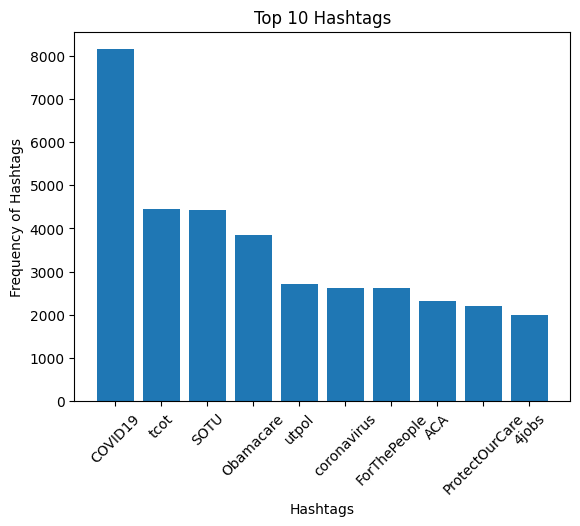

In [77]:
# Creating a bar chart to plot the hashtags
fig, ax = plt.subplots()
ax.bar(x=hashtag_series.index, height=hashtag_series)
ax.set_ylabel("Frequency of Hashtags")
ax.set_xlabel("Hashtags")
ax.set_title("Top 10 Hashtags")
ax.tick_params(axis="x", rotation=45)
plt.show()

<br></br>

##### Part c) 
To answer this question, first please read the description above DW-NOMINATE scores provided at the beginning of this assignment document. Then, please divide your training dataset into four subsets by focusing on the following ideological dimensions:

a. Group 1: Dim 1 (0 to 1), Dim 2 (0 to 1)

b. Group 2: Dim 1 (0 to 1), Dim 2 (0 to -1)

c. Group 3: Dim 1 (0 to -1), Dim 2 (0 to 1)

d. Group 4: Dim 1 (0 to -1), Dim 2) (0 to -1)

Repeat the same analysis you have done in part b). Please create four separate bar charts with four different colors this time. Do you observe any patterns? Are your findings similar to or different from your findings in part b) ?. Please explain. Write your findings in the report. (Add the bar charts to the report.) (4 points) (2 points for graduate students)

In [158]:
# Defining conditions to split the data into 4 quadrants
conditions = {
    1: (training_df["dim1_nominate"]>0) & (training_df["dim2_nominate"]>0),

    2: (training_df["dim1_nominate"]>0) & (training_df["dim2_nominate"]<0),
    
    3: (training_df["dim1_nominate"]<0) & (training_df["dim2_nominate"]>0),
    
    4: (training_df["dim1_nominate"]<0) & (training_df["dim2_nominate"]<0),
}

In [159]:
groups = [training_df[conditions[i]] for i in range(1, 5)]
grp1, grp2, grp3, grp4 = groups

In [160]:
# Checking if the data has been split correctly
grp1.shape[0] + grp2.shape[0] + grp3.shape[0] + grp4.shape[0] == training_df.shape[0]

True

In [161]:
def plot_frequent_hashtags(df: pd.DataFrame, color: str, title: str):
    """Find the 10 most frequent hashtags and plot its bar chart."""

    df = df.copy()  # Create a copy to avoid the warning
    df.loc[:, "hashtags"] = df["hashtags"].apply(lambda x: x.split())
    df = df.explode("hashtags")
    
    hs = df["hashtags"].value_counts().head(10)

    fig, ax = plt.subplots()
    ax.bar(x=hs.index, height=hs, color=color)
    ax.set_ylabel("Frequency of Hashtags")
    ax.set_xlabel("Hashtags")
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)
    plt.show()

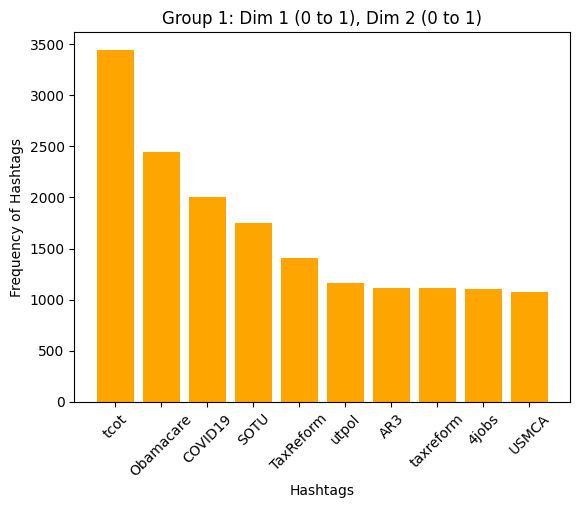

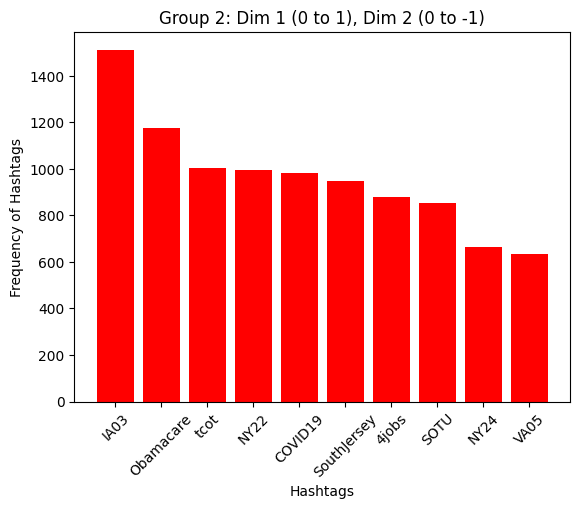

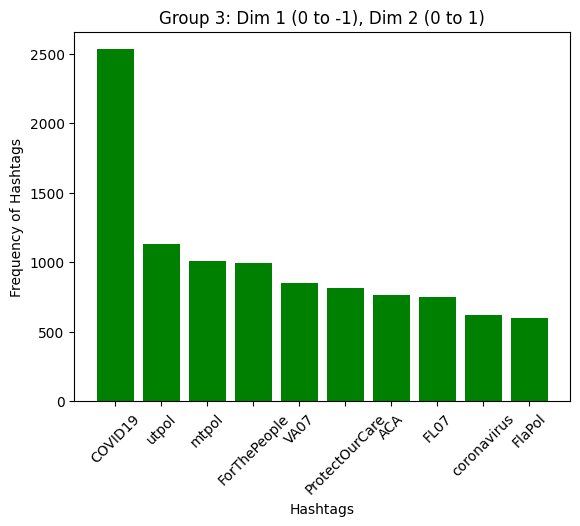

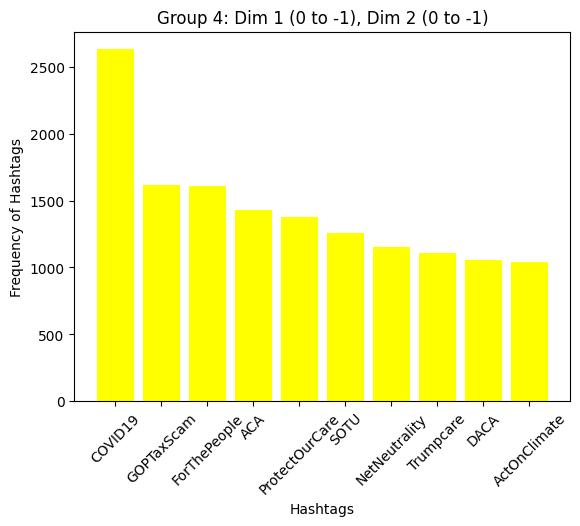

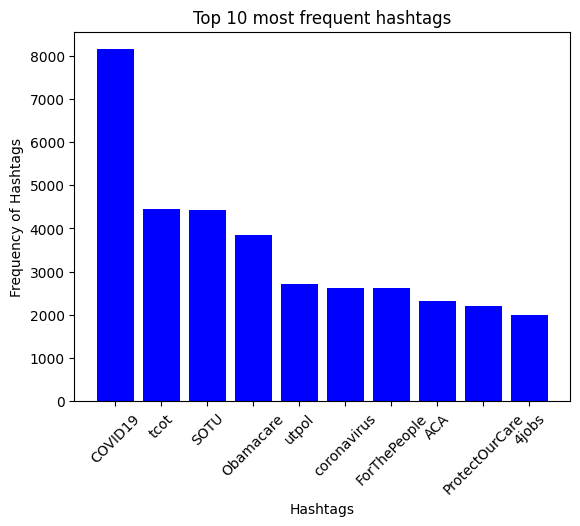

In [163]:
plot_frequent_hashtags(grp1, "orange", "Group 1: Dim 1 (0 to 1), Dim 2 (0 to 1)")
plot_frequent_hashtags(grp2, "red", "Group 2: Dim 1 (0 to 1), Dim 2 (0 to -1)")
plot_frequent_hashtags(grp3, "green", "Group 3: Dim 1 (0 to -1), Dim 2 (0 to 1)")
plot_frequent_hashtags(grp4, "yellow", "Group 4: Dim 1 (0 to -1), Dim 2 (0 to -1)")
plot_frequent_hashtags(training_df, "blue", "Top 10 most frequent hashtags")

<br></br>

##### Part d) 
Divide the training dataset into two along the 1st dimension. All observations that have a value bigger than zero (in the 1st dimension) should be designated as ‘conservative’, all other observations should be designed as ‘liberal’. Create a ridge plot that shows the changes in these values (1st dimension) through the years for two different ideological groups. Color the conservative group as red, color the liberal group as blue. (Note: This graph will structually be similar to, but empirically slightly different from the graph in the first page of the assignment [since, the training dataset does not contain any information about party membership.]) Do you observe any changes over the years? Please explain. Write your findings in the report. (Add the ridge plot to the report.) (4 points) (2 points for graduate students)

In [ ]:
# Step 1: Extract relevant columns and sort by year
df = training_df[['dim1_nominate', 'year']].copy().sort_values(by='year')

# We use groupby to process each year and apply a custom balancing function to balance the number of conservative and liberal values for each year
def balance_groups(df_year):
    conservative = df_year[df_year['dim1_nominate'] > 0]['dim1_nominate']
    liberal = df_year[df_year['dim1_nominate'] <= 0]['dim1_nominate']
    
    # Calculate the length difference and create NaN series to balance
    len_diff = len(conservative) - len(liberal)
    if len_diff > 0:
        liberal = pd.concat([liberal, pd.Series([np.nan] * len_diff)], ignore_index=True)
    elif len_diff < 0:
        conservative = pd.concat([conservative, pd.Series([np.nan] * abs(len_diff))], ignore_index=True)
    
    return pd.DataFrame({
        'year': df_year['year'].iloc[0],
        'conservative': conservative.values,
        'liberal': liberal.values
    })

df_balanced = df.groupby('year').apply(balance_groups).reset_index(drop=True)

/scratch/jpatil/tmp/ipykernel_34671/68198699.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('year').apply(balance_groups).reset_index(drop=True)
/scratch/jpatil/my-conda/envs/nlp/lib/python3.10/site-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


<Figure size 1000x800 with 0 Axes>

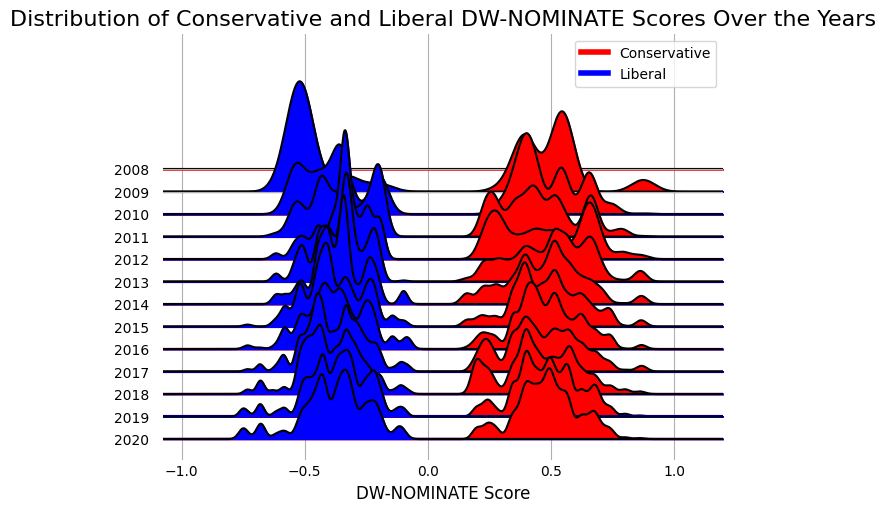

In [40]:
# Plotting the ridge plot with consistent red and blue colors
plt.figure(figsize=(10, 8))

fig, axes = joypy.joyplot(
    data=df_balanced, by="year", overlap=2, 
    grid=True, fill=True, linecolor="black", 
    color=["red", "blue"]
)

plt.xlabel("DW-NOMINATE Score", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.title("Distribution of Conservative and Liberal DW-NOMINATE Scores Over the Years", fontsize=16)
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=4, label='Conservative'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Liberal')
], loc='upper right')

plt.show()

Based on the provided plot and the described task, here's an analysis of the changes in the dim1_nominate values over the years for the conservative and liberal groups:

Observations:

Liberal Group (Blue) Trends:

From 2008 to 2010, there is a noticeable concentration of values around -0.5. This suggests a relatively stable ideological positioning in these years.
After 2010, the distribution of liberal values becomes more spread out, indicating a diversification in ideological positions. However, the peak of the distribution remains around -0.5.
In later years, particularly after 2015, there is a slight shift towards less extreme values (closer to 0), suggesting a potential moderation in some segments of the liberal group.

Conservative Group (Red) Trends:

From 2008 to 2012, there is a distinct peak around 0.5, indicating a strong conservative stance.
After 2012, there appears to be a shift in the distribution, with values becoming more spread out, and the peak shifts slightly to the right (closer to 1), indicating a possible intensification of conservative positions.
The distribution remains concentrated and doesn’t exhibit much change after 2015, maintaining a high concentration around the conservative spectrum.
General Observations:

There is a clear distinction between the liberal and conservative groups in the dim1_nominate scores, with minimal overlap.
Over the years, the conservative group's scores appear to become more extreme, while the liberal group's distribution spreads out but remains centered around the same position.
The distinct separation between the two groups suggests increasing polarization in their ideological positions.

Conclusion:
The plot indicates increasing polarization over the years, with conservative scores becoming more extreme and the liberal scores spreading out slightly but remaining consistently on the left side of the spectrum. This trend reflects a growing divide in the ideological positions of the two groups.

<br></br>

##### Part e) 
Finally, find the top-10 tweets that are ideologically most different from each other by calculating
the Euclidean distances for the following:

a. Top-10 most distant tweets along both dimensions

b. Top-10 most distant tweets along the 1st dimension

c. Top-10 most distant tweets along the 2nd dimension

Please report your findings in the form of tables [tweet pairs that are ideologically distant and the
distance value]. Do you observe any patterns? Please explain. Write your findings in the report.
(Add the tables to the report.) (Note: If there are more than 10 tweet pairs with the same distance,
you are welcome to choose the most distant tweet pairs that you find the most interesting.) (4
points) (2 points for graduate students)

<br></br>

Part e : a) Top-10 most distant tweets along both dimensions

In [81]:
# Checking unique values in dim1 and dim2 and their frequencies
training_df['dim1_nominate'].unique().shape[0], training_df['dim2_nominate'].unique().shape[0]

(391, 391)

In [82]:
# Extracting unique values for both dimensions
unique_points = training_df[['dim1_nominate', 'dim2_nominate']].drop_duplicates()

# Generating all possible unique pairs
pairs = list(combinations(unique_points.values, 2))

# Calculating the Euclidean distance for each pair
def euclidean_distance(pair):
    point1, point2 = pair
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

distances = [(pair, euclidean_distance(pair)) for pair in pairs]

# Finding the pair with the maximum distance
most_distant_pair, max_distance = max(distances, key=lambda x: x[1])

print(f"The most distant pair[dim1, dim2] is \nPair 1: {most_distant_pair[0]}\nPair 2: {most_distant_pair[1]} \nwith a distance of {max_distance:.2f}")


The most distant pair[dim1, dim2] is 
Pair 1: [-0.7509898   0.48995435]
Pair 2: [ 0.87555602 -0.54444456] 
with a distance of 1.93


In [83]:
# Get the count of unique pairs of most_distant_pair
dim_series = training_df.groupby(['dim1_nominate', 'dim2_nominate']).size()
pair_1 = dim_series.loc[tuple(most_distant_pair[0])]
pair_2 = dim_series.loc[tuple(most_distant_pair[1])]

print(f"Pair 1: {pair_1} tweets\nPair 2: {pair_2} tweets")

Pair 1: 1202 tweets
Pair 2: 694 tweets


In [52]:
tweets_pair_1 = training_df[(training_df['dim1_nominate'] == most_distant_pair[0][0]) & (training_df['dim2_nominate'] == most_distant_pair[0][1])]
twts_extreme_1 = tweets_pair_1.iloc[:10, :]['full_text'].apply(html.unescape)

tweets_pair_2 = training_df[(training_df['dim1_nominate'] == most_distant_pair[1][0]) & (training_df['dim2_nominate'] == most_distant_pair[1][1])]
twts_extreme_2 = tweets_pair_2.iloc[:10, :]['full_text'].apply(html.unescape)

# Create a dataframe to display the tweets
extreme_tweets_df = pd.DataFrame({
    'Tweet 1': twts_extreme_1.values,
    'Tweet 2': twts_extreme_2.values,
    "Distance": [max_distance] * 10
})

pd.set_option('display.max_colwidth', None)
extreme_tweets_df

,Tweet 1,Tweet 2,Distance
0,This weekly roundup: I voted to pass Con. Castro’s resolution 2 block Trump's #FakeEmergency declaration & the 1st major gun safety legislation in over 25 years. My colleagues and I on @HouseJudiciary also investigated the admin’s harmful separation policy at the border.#TX29 https://t.co/xUTwAfVG1i,"In the wake of #ebola, continued economic progress is key for #Liberia. Watch live as I speak to @CGDev at 9:30am ET https://t.co/sXDuRhMN6O",1.927598
1,"In Discovery Green, took a knee with @RepAlGreen, @houmayor Sylvester Turner, and thousands of Houstonians to protest police brutality, racism, and white supremacy in America.\n\nHouston’s heart is with #GeorgeFloyd and his family this afternoon. https://t.co/0bO3FWjifG","Congrats to my alma mater, Snowflake Jr. HS, for selection as a '17 #SamsungSolve STEAM finalist. #SamsungSolveSJHS https://t.co/RSXZwny23l",1.927598
2,Literally changing lives #ForThePeople!!! https://t.co/RR6YzdKkIc,Just got my copy of the #healthcare bill and I'm going to take time to thoroughly read and review it,1.927598
3,Roland Gramajo was arrested by @ICEgov on Thursday.\n\nHe’s a leader in the #Houston #Latino community and a father of five American children.\n\nPeople call me radical for calling to #AbolishICE.\n\nhttps://t.co/WPOC90OJP0,".@FoxNews @SpecialReport on my effort w @dougducey & @SenJohnMcCain to get #AZ out of the oversized, overworked & oft-overturned #9thCircuit https://t.co/TtdteiTNmP",1.927598
4,"This week, my constituent Anna Alvarez joined me for #SOTU2020 to highlight why we must #RaiseTheWage.\n\nThe impeachment trial came to an end. While acquitted, Trump was NOT exonerated.\n\nLastly, we also passed bills such as the #PROAct that protect workers' rights to join a union. https://t.co/rI0C4eDxad",Cheryl bags trash @justserve project at Salt River this morning. LDS and other faiths team up to serve. #justserve https://t.co/rpU1Crk3gN,1.927598
5,.@HoustonTX launched its #Census2020 YES! to the Census campaign because everyone must be counted.\n\nThe Census will determine how billions in federal funds will be allocated across the country.\n\nWe must make sure our community gets its fair share. https://t.co/5buMKb3WLw,"It's my Earth, Wind & Fire week so #LetsGroove w 3 more bills to make rural AZ a #ShiningStar of growth & investment https://t.co/LQq76qrcIY",1.927598
6,#DontLookAway from the inhumane conditions that Trump is forcing asylum seekers to live in.\n\nHis anti-immigrant agenda continues to risk the lives of people who just want an opportunity at the American Dream.\n\nThese policies are inconsistent with our values as Americans. https://t.co/6DuOmObNg6,#Wastebook sparking lots of great convo but none more entertaining than this @oreillyfactor @greggutfeld @bernieandsid exchange on @foxnews https://t.co/5vXvxWlsYR,1.927598
7,"Here's your weekly update! This week, we celebrated #VeteransDay, fought for our #Dreamers, passed a resolution on the #ERA, marked up bills in the Financial Services Committee that will protect consumers, and I also introduced a new bill, the Stop EITC and CTC Seizures Act. https://t.co/58ieciGALj",Wishing a happy 100th birthday to our great state of Arizona today. Here’s to the all that the next 100 years will bring. #AZcentennial,1.927598
8,"We have a responsibility to our teachers and students, which is why I led a letter urging TEA Commissioner @MikeMorath to reverse his decision not to directly disburse #CARESAct funds to local education agencies. https://t.co/fUJ5mvXR1h",Tucson Day. Thanks @wakeuptucson and @jonjustice for having me on this morning. #DayInTheLife http://t.co/pzdcYy7tmC,1.927598
9,America needs all people to wear a face mask. #MaskUp https://t.co/U3NKzJhypa,"I'm voting yes on #Prop123. Our kids attend public schools, and it's the best way to provide additional resources with no tax increase.",1.927598


<br></br>

Part e : b) Top-10 most distant tweets along the 1st dimension

In [84]:
import numpy as np
import pandas as pd
from itertools import combinations

def find_most_distant_pairs(df, column_name):
    """
    Finds the most distant pair of unique values in a specified column of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to evaluate.
    
    Returns:
    tuple: The most distant pair of unique values and their Euclidean distance.
    """
    # Extract unique values from the specified column
    unique_values = df[column_name].unique()

    # Find the pair with the maximum Euclidean distance
    most_distant_pair = max(combinations(unique_values, 2), key=lambda pair: np.abs(pair[0] - pair[1]))

    # Calculate the Euclidean distance for the most distant pair
    max_distance = np.abs(most_distant_pair[0] - most_distant_pair[1])

    # Display the result
    print(f"The most distant pair [{column_name}] is\n"
          f"Pair 1: {most_distant_pair[0]}\n"
          f"Pair 2: {most_distant_pair[1]}\n"
          f"with a distance of {max_distance:.2f}")
    
    return most_distant_pair[0], most_distant_pair[1], max_distance


In [89]:
import pandas as pd
import html

def get_top_tweets(df, col, dim_min, dim_max, max_dist, n=10):
    """
    Retrieve the top tweets from two distinct groups within a DataFrame and create a DataFrame 
    containing pairs of these tweets along with a specified distance.

    Args:
        df (pd.DataFrame): The DataFrame containing tweet data.
        col (str): The column name to filter the DataFrame by.
        dim_min: The value representing the first group in the specified column.
        dim_max: The value representing the second group in the specified column.
        max_dist (float): The distance value to be displayed in the resulting DataFrame.
        n (int, optional): The number of top tweets to retrieve from each group. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing pairs of tweets from the two groups and the specified distance.

    Raises:
        ValueError: If the number of tweets retrieved from the two groups is not equal.
    """
    # Extracting top n tweets for each group
    tweets_1 = df[df[col] == dim_min].tail(n)['full_text'].apply(html.unescape)
    tweets_2 = df[df[col] == dim_max].tail(n)['full_text'].apply(html.unescape)

    if len(tweets_1) != len(tweets_2):
        raise ValueError("The number of tweets retrieved from the two groups are not equal.")

    # Create a DataFrame with paired tweets and the specified distance
    extreme_tweets_df = pd.DataFrame({
        'Tweet 1': tweets_1.values,
        'Tweet 2': tweets_2.values,
        'Distance': max_dist
    })

    return extreme_tweets_df

In [96]:
dim1_min, dim1_max, max_dist_1 = find_most_distant_pairs(training_df, "dim1_nominate")
dim1_min, dim1_max, max_dist_1

The most distant pair [dim1_nominate] is
Pair 1: -0.750989797
Pair 2: 0.8755560189810438
with a distance of 1.63


(-0.750989797, 0.8755560189810438, 1.6265458159810438)

In [97]:
get_top_tweets(training_df, "dim1_nominate", dim1_min, dim1_max, max_dist=max_dist_1)

,Tweet 1,Tweet 2,Distance
0,.@VP here’s an idea:\n\nYou can honor the victims of today’s shooting with action. Urge McConnell to allow a vote on HR 8 and HR 1112. \n\nYour thoughts and prayers won’t undo the violence in #Texas. #DoSomething #texasshooting #odessashooting https://t.co/h2LvnZGo0o,"What do man caves, a secret agent & pig flatulence have in common? @EPA & your taxdollars #ScienceOfSplurging http://t.co/2gAKOMyS9A",1.626546
1,"The arc of the moral universe is long, but today it was further bent towards justice for #LGBTQ Americans.\n\nIn America, no one should be fired for their sexual orientation or gender identity. https://t.co/EbMeUkFMHx",RT @Jason_Samuels: Sen. @JeffFlake isn't messing around at the #NPCBee. Taps @ScrippsBee champ Gokul Venkatachalam for advice #npcb https:/…,1.626546
2,"Here’s the latest on #Imelda, more heavy rain is expected. Make sure to stay informed and don’t let your guard down. #houwx #txwx #HouNews https://t.co/FmQLiQQHU7",Watching Dallin's football scrimmage at 2:30pm. 109 *F. #sweatfest http://t.co/e3KDXRvuaX,1.626546
3,More awesome #GoTexanDay spirit and a fired up group of seniors at Denver Harbor MSC. I ran into an intense game of bingo and had to play along! #TX29 https://t.co/7rAHPCPhEN,"@franklinblog, #438days was an INCREDIBLE read. Great escape from politics. Thanks.",1.626546
4,I am proud to join @RepDMP and the rest of my colleagues on the @HispanicCaucus Women’s Task Force to express my support for the #LatinaProsperity Principles. https://t.co/jt3UWqXCig,Having trouble with a federal agency? Stop by my staff's #Scottsdale office hours tomorrow to see if we can help. http://t.co/kLrwyZktKt,1.626546
5,"His testimony has only enabled Trump’s #CultureOfCorruption.\n \nI took an oath to support and defend the #Constitution.\n\nOn today’s #ConstitutionDay, we are holding #CoreyLewandowski, @realDonaldTrump, and his administration accountable because no one is above the law.",Enjoyed meeting with @DodieLondenEIPS National Excellence in Public Service participants from #AZ this morning https://t.co/UHxy6Fe3KG,1.626546
6,.@hcphtx has launched a #COVID19 Dashboard that will provided regularly updated information about the number of active #Coronavirus cases in Harris County.\n\nView it now: https://t.co/NTNJJkaPa7 https://t.co/j42OkWovDJ,With my friend President Loeak of the Marshall Islands. Take me back to the islands! #RivalSurvival @MartinHeinrich http://t.co/WuUk6RGKJ4,1.626546
7,Gracias @USHCC for having the opportunity to share with our strong Hispanic #Entrepreneurs our stories during the In Her Footsteps Panel. The work you do for Hispanic businneses is more important than ever! https://t.co/RukvJN4CLa,Great run by US Women’s Ice Hockey Team in #Sochi! Proud to see Arizonan Lyndsey Fry @fry_X_cycle awarded a silver medal.,1.626546
8,"Melrose Park Civic Club was a good crowd last night. #TeamSylvia, @RepWalle and others gave updates on community happenings. #TX29 https://t.co/knqSH6ZclD",One of the best Thanksgiving traditions #turkeybowl https://t.co/mgkkhMFFjr,1.626546
9,Estos son los distritos escolares del área de #Houston que cancelan actividades por causa de #Imelda. \n#txwx #houwx \n\nhttps://t.co/ngLD9iihFA,"So, if ""low level"" staffers at the IRS can target #teaparty and #patriot, what's next? Party registration? Donation history?",1.626546


<br></br>

Part e : c) Top-10 most distant tweets along the 2nd dimension

In [94]:
dim2_min, dim2_max, max_dist_2 = find_most_distant_pairs(training_df, "dim2_nominate")
dim2_min, dim2_max, max_dist_2

The most distant pair [dim2_nominate] is
Pair 1: -0.982897438
Pair 2: 0.7265932703738273
with a distance of 1.71


(-0.982897438, 0.7265932703738273, 1.7094907083738273)

In [95]:
get_top_tweets(training_df, "dim2_nominate", dim2_min, dim2_max, max_dist=max_dist_2)

,Tweet 1,Tweet 2,Distance
0,"My mommy, Sandy, was beaten for being too pretty, too ugly, too smart, too dumb, too black. Let us reject the myth that strong women, bold women, independent women, do not find themselves in the throes of violence at the hands of someone who claimed to love them. #VAWA #VAWA19 https://t.co/9dXeUsCKTd","As arguments begin in the Trump Administration's lawsuit to invalidate the ACA, I joined colleagues to tell the story of Rob & Debbie Rose of Rowlett, who were able to purchase insurance thanks to the ACA. We must work together to #ProtectOurCare and help families like the Roses. https://t.co/JRDOfb8iuT",1.709491
1,"Black youth in America are facing a #MentalHealth crisis. They face disproportionate barriers to accessing quality, affordable mental health care, and startling new data reveals that they are dying by suicide at higher rates than their white peers.\n\nhttps://t.co/fRqzgIWidn","As we all reflect on #IndependenceDay, and safely spend time with loved ones, let us remember the health care workers and many others who are sacrificing so much to keep us healthy and save lives. #HappyFourthofJuly https://t.co/kXFZ5LjtJp",1.709491
2,"From #PublicCharge to attempts to end #MedicalDeferredAction, the cruelty is the point. \n\nAs the occupant of the White House continues attacking our immigrant neighbors, I’m working with my #TriCaucus colleagues to oppose this cruelty. #NoToPublicCharge https://t.co/GNjqGIfRR9","As your Representative, one of my top priorities is to stay connected to North Texas. Make sure to follow me on social media and subscribe to my newsletter to stay updated on all my latest work in Congress for #TX32. https://t.co/4AvsLhKbMZ",1.709491
3,"As a child to witness the abuse & degradation of the person who is your world, your everything - it is an image, a feeling, which never leaves. Today’s passage of #VAWA shows the nation that we say NO MORE. #VAWA19",Had a great discussion today with folks at the @NDCC on my work in Congress for #TX32 and how we can grow our economy so that it benefits everyone in our region. https://t.co/LqLwkWJswE,1.709491
4,".@TheBlackCaucus’s 21st Century Infrastructure Principles are a bold step toward ensuring our infrastructure investments center sustainability, accessibility & community-connectedness -affirming transportation & housing #justice for all. https://t.co/s3urGA8dyL]","Our small businesses are hurting during this pandemic, which is why I voted for the #CARESAct to help bring resources and aid to our community. Dallas County recently expanded its efforts to help and some may qualify for more assistance. Learn more here: https://t.co/fbaZ48HoUt",1.709491
5,"RT @NotoriousVOG: C'Mon! I so AGREE with THIS, all of it, every single word! @RepPressley 👏🏾✊🏾🙌🏾 #UrbanAgenda #BOSpoli #MApoli #Blacktwitte…","Welcome news for North Texans hurting from the economic fallout of #COVID19. @PUCTX will suspend shutoffs for Texans impacted. If you are unable to pay your water or power bills, please make sure to call your provider and ask for assistance. https://t.co/EYAq1fx6aR",1.709491
6,#BlackLivesMatter. Period. \n\nI commend @JessJTang & @BTU66 for recognizing our young people as leaders in the civil rights movement. We must remain committed to lifting the goals of @BlmBoston during this week & all year round as we work to actualize justice for all. https://t.co/qMYMpfjfFU,"Thanks to everyone who joined my #TX32 telephone town hall tonight. Listening to you and answering your questions is such an important part of my job. \n\nIf you want to join future town halls or stay updated on my work in Congress, sign up for my newsletter https://t.co/jhSKTinCEm https://t.co/U0V97a50I8",1.709491
7,Starving a child is violence. \n\nPunishing a mother and her family is violence \n\nContempt for poverty is violence. \n\nThis administration's attacks on #SNAP would threaten benefits for more than 100000 ppl in Massachusetts which includes 72000 children. This is child abus

<br></br>

#### Section B

##### a) Write a ‘text cleaner’ function that does the following in the full_text column: 
(i) remove stopwords3
(ii) remove all words that are shorter than 3 characters, 
(iii) remove all links (startingwith http), 
(iv) remove emojis, 
(v) remove punctuation. 

Attach the code you wrote to the lemmatizer.py file in the project folder. Run the lemmatizer function and create ‘cleaned and lemmatized’ version of text column. (You can name the new column as text_clean). After the cleaning, expand the table you have created in Section A) by calculating minimum, average, median, and maximum for the newly created text_clean column (#characters and #words). (5 points)

##### Lemmatize Function

In [106]:
import string

# Initialize resources once, outside of the functions
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  # Load stopwords once


def tweet_cleaner(tweet):
    # Decode HTML entities
    tweet = html.unescape(tweet)

    # Remove links (starting with http/https/ftp etc.)
    tweet = re.sub(r'http\S+|www\S+|ftp\S+', '', tweet)
    
    # Remove emojis using a regex pattern
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # Flags
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"  # Additional symbols
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)
    
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the tweet and remove stopwords and words shorter than 3 characters
    words = word_tokenize(tweet)
    filtered_words = [word for word in words if word.lower() not in stop_words and len(word) >= 3]
    
    # Join the filtered words back into a single string
    cleaned_tweet = ' '.join(filtered_words)

    return cleaned_tweet


# Function to convert nltk POS tags to WordNet POS tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# Function to lemmatize the cleaned tweet
def lemmatize_tweet(tweet):
    tweet = tweet_cleaner(tweet)
    nltk_tagged = nltk.pos_tag(word_tokenize(tweet))  # POS tagging

    # Map words to their WordNet POS tag
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_tweet.append(word)  # No tag available, append as is
        else:
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))  # Lemmatize
    return " ".join(lemmatized_tweet)

[nltk_data] Downloading package stopwords to /home/jpatil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jpatil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jpatil/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jpatil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jpatil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Apply the Lemmentizer to the tweets

In [107]:
def parallelize_dataframe(df, func, num_cores):
    """
    Parallelizes the application of a function across a DataFrame using multiple cores.

    Args:
        df (pd.DataFrame): The DataFrame to be processed.
        func (callable): The function to apply to each row of the DataFrame.
        num_cores (int): The number of cores to use for parallel processing.

    Returns:
        pd.DataFrame: The DataFrame resulting from applying the function to each row in parallel.
    """
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        # Apply the function to each row of each split DataFrame part
        results = pool.map(lambda df_part: df_part.apply(func), df_split)
    return pd.concat(results)

num_cores = multiprocessing.cpu_count()

# Parallelize the 'lemmatize_tweet' function for each row in the 'full_text' column
training_df['text_clean'] = parallelize_dataframe(training_df['full_text'], lemmatize_tweet, num_cores)
df_test['text_clean'] = parallelize_dataframe(df_test['full_text'], lemmatize_tweet, num_cores)

/scratch/jpatil/my-conda/envs/nlp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/scratch/jpatil/my-conda/envs/nlp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


##### Summary Statistics

In [108]:
# remove empty tweets 
training_df = training_df[training_df['text_clean'].str.len() > 0]

# Create new columns for character and word counts
training_df['char_count'] = training_df['text_clean'].apply(len)  # Number of characters
training_df['word_count'] = training_df['text_clean'].apply(lambda x: len(x.split()))  # Number of words

# Calculate the required statistics for character count
char_min = training_df['char_count'].min()
char_max = training_df['char_count'].max()
char_mean = training_df['char_count'].mean()
char_median = training_df['char_count'].median()

# Calculate the required statistics for word count
word_min = training_df['word_count'].min()
word_max = training_df['word_count'].max()
word_mean = training_df['word_count'].mean()
word_median = training_df['word_count'].median()

# Print the results
print("Character Count Statistics:")
print(f"Minimum: {char_min}, Maximum: {char_max}, Average: {char_mean}, Median: {char_median}")

print("\nWord Count Statistics:")
print(f"Minimum: {word_min}, Maximum: {word_max}, Average: {word_mean}, Median: {word_median}")

# Optionally, you can add these stats to the DataFrame as a new row for reference
stats_df = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median'],
    'Character Count': [char_min, char_max, char_mean, char_median],
    'Word Count': [word_min, word_max, word_mean, word_median]
})

print("\nSummary Statistics DataFrame for 'text_clean':")
print(stats_df)

Character Count Statistics:
Minimum: 3, Maximum: 430, Average: 106.9294459332006, Median: 94.0

Word Count Statistics:
Minimum: 1, Maximum: 43, Average: 14.17718759824543, Median: 12.0

Summary Statistics DataFrame for 'text_clean':
   Metric  Character Count  Word Count
0     Min         3.000000    1.000000
1     Max       430.000000   43.000000
2    Mean       106.929446   14.177188
3  Median        94.000000   12.000000


In [111]:
training_df.to_csv("/scratch/jpatil/workspace/mini_project/training_data_cleaned.csv", index=False)
df_test.to_csv("/scratch/jpatil/workspace/mini_project/test_data_cleaned.csv", index=False)

<br></br>

##### b) Perform (i) LDA and (ii) Non-negative Matrix Factorization for topic analysis. 
Please use the text_clean column you have created above. Set the number of clusters/topics to 10 (ten) and extract the topics in an unsupervised manner. Adjust any parameters as you see fit. Analyze the results. Compare the results of both models. Interpret your findings and add your findings to the report. (5 points)

#### NMF

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from joblib import Parallel, delayed, parallel_backend
import os
import matplotlib.pyplot as plt

# Utilize all cores for parallel operations
n_cores = os.cpu_count()
os.environ['OPENBLAS_NUM_THREADS'] = str(n_cores)
os.environ['MKL_NUM_THREADS'] = str(n_cores)
os.environ['NUMEXPR_NUM_THREADS'] = str(n_cores)
os.environ['OMP_NUM_THREADS'] = str(n_cores)

In [31]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english', max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(training_df["text_clean"])

n_topics = 10

In [32]:
# Initialize the NMF model with parallel backend
nmf_model = NMF(n_components=n_topics, random_state=42, beta_loss='kullback-leibler', max_iter=5000, solver='mu', init='nndsvda')

# Use parallel backend for faster NMF computation
with parallel_backend('threading', n_jobs=n_cores):
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Display the top words for each topic
for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: make, like, continue, america, important, way, work, future, security, use
Topic 2: today, honor, celebrate, office, member, national, remember, friend, event, staff
Topic 3: great, thanks, good, student, come, visit, work, state, school, meet
Topic 4: family, thank, day, happy, woman, country, nation, life, fight, let
Topic 5: time, house, vote, congress, act, pass, senate, week, end, action
Topic 6: join, live, watch, hear, talk, tonight, discuss, tcot, tune, forward
Topic 7: americans, people, trump, million, know, obamacare, plan, say, want, realdonaldtrump
Topic 8: help, job, need, business, tax, economy, learn, program, worker, federal
Topic 9: support, proud, health, care, covid19, community, veteran, child, effort, public
Topic 10: year, new, president, read, stand, law, potus, sign, congrats, ago


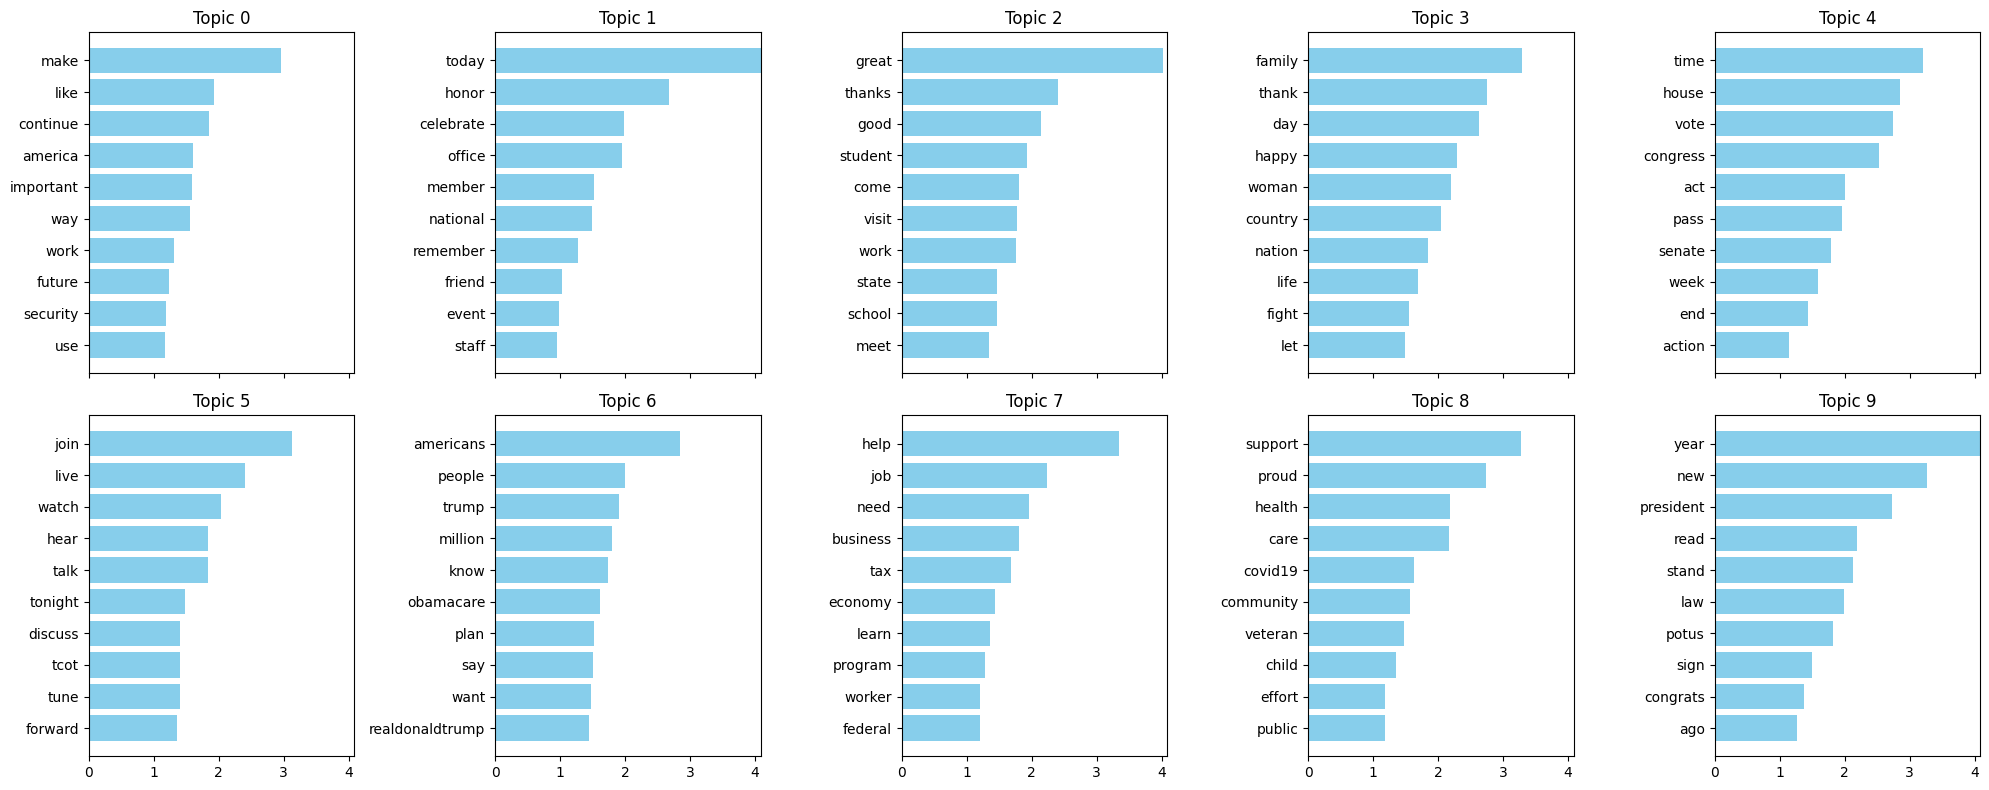

In [33]:
# Function to plot top words for each topic
def plot_top_words_per_topic(H, feature_names, n_top_words, topic_idx):
    topic = H[topic_idx]
    top_words_indices = topic.argsort()[:-n_top_words - 1:-1]  # Indices of top words
    top_words = [feature_names[i] for i in top_words_indices]
    top_words_scores = topic[top_words_indices]

    # Create a DataFrame for plotting
    df = pd.DataFrame({'Word': top_words, 'Score': top_words_scores})
    df = df.sort_values(by='Score', ascending=True)  # Sort for better visualization

    return df

# Plotting all topics in a single figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True)

for topic_idx, ax in enumerate(axes.flatten()):
    df = plot_top_words_per_topic(H, feature_names, 10, topic_idx)
    ax.barh(df['Word'], df['Score'], color='skyblue')
    ax.set_title(f'Topic {topic_idx}')
    ax.set_xlim(0, df['Score'].max() + 0.005)

plt.tight_layout()
plt.show()

#### LDA : <i>Topic Modeling</i>

In [10]:
# Function to parallelize DataFrame processing
def parallelize_dataframe(df, func, num_cores):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        # Apply the function to each row of each split DataFrame part
        results = pool.map(lambda df_part: df_part.apply(func), df_split)
    return pd.concat(results)

# Apply the function in parallel
num_cores = multiprocessing.cpu_count()

# Parallelize the 'lemmatize_tweet' function for each row in the 'full_text' column
training_df['text_clean'] = parallelize_dataframe(training_df['full_text'], lemmatize_tweet, num_cores)

/scratch/jpatil/my-conda/envs/nlp/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [11]:
training_df["full_text"]

0         WATCH my speech on the @SenateFloor to learn m...
1         Boehner delays leadership races. Only speaker ...
2         I'll be sharing #scarynumbers about #governmen...
3         #OTD in '64, LBJ took important step towards f...
4         My bipartisan bill is a step toward protecting...
                                ...                        
333982    I am working to make Social Security stronger ...
333983    Climate change -&gt; altered CA forest ecosyst...
333984    The @USChamber and other business lobbying gro...
333985    I look forward to answering constituent’s ques...
333986    In December, historic @StCharlesCity holds “Ch...
Name: full_text, Length: 333987, dtype: object

In [12]:
training_df["text_clean"]

0         WATCH speech SenateFloor learn PatientFreedomA...
1         Boehner delay leadership race speaker election...
2         Ill share scarynumbers governmentspending rest...
3         OTD LBJ take important step towards fulfil pro...
4         bipartisan bill step toward protect expand aff...
                                ...                        
333982    work make Social Security strong generation co...
333983    Climate change alter forest ecosystems dangero...
333984    USChamber business lobby group need become par...
333985    look forward answer constituent question start...
333986    December historic StCharlesCity hold Christmas...
Name: text_clean, Length: 333987, dtype: object

['watch', 'speech', 'senatefloor', 'learn', 'mean', 'west', 'virginia']


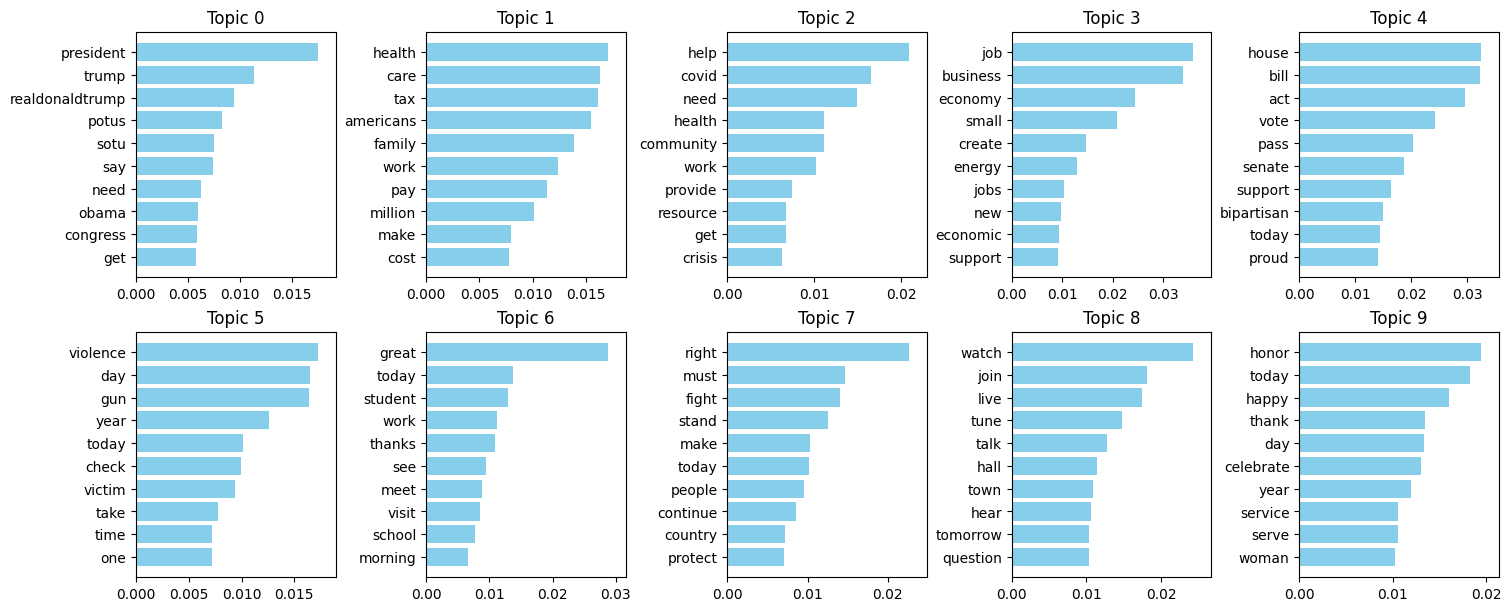

In [14]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

training_texts = training_df['text_clean'].astype(str).tolist()

# Preprocessing - Tokenize the text data: converting to list of tokens using gensim's simple_preprocess
texts = [simple_preprocess(doc) for doc in training_texts]
print(texts[0])

# Creating a dictionary and corpus needed for LDA
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model using LdaMulticore
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, passes=2000, workers=30)


topics_data = []
num_words = 10  # Number of top words to extract for each topic

# Extract the topics and their top words
for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words):
    topics_data.append((idx, [(word, round(weight, 4)) for word, weight in topic]))

# Plotting the words for each topic as horizontal bar charts
n_cols = 5
n_topics = len(topics_data)
n_rows = (n_topics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each topic's top words as horizontal bar charts
for ax, (topic_num, words_weights) in zip(axes, topics_data):
    # Extract words and their corresponding weights
    words, weights = zip(*words_weights)
    
    # Plot horizontal bar chart
    ax.barh(words, weights, color='skyblue')
    ax.set_title(f"Topic {topic_num}")
    ax.invert_yaxis()  # Invert y-axis to have the highest weight on top
    ax.set_xlim(0, max(weights) * 1.1)  # Set x-axis limit

# Hide any remaining empty subplots
for ax in axes[n_topics:]:
    ax.axis('off')

plt.show()


<br></br>

### Part II: Model Creation and Prediction

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import torch
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
df = pd.read_csv('/scratch/jpatil/workspace/mini_project/training_data_cleaned.csv')
df_test = pd.read_csv('/scratch/jpatil/workspace/mini_project/test_data_cleaned.csv')

df['text_clean'] = df['text_clean'].fillna('').astype(str)
df_test['text_clean'] = df_test['text_clean'].fillna('').astype(str)

#### Feature Engineering

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("m-newhauser/distilbert-political-tweets")
model = AutoModelForSequenceClassification.from_pretrained("m-newhauser/distilbert-political-tweets").to(device)

# Custom Dataset to handle batching
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to predict political bias in batches with mixed precision
def predict_political_bias_batch(texts, batch_size=32):
    dataset = TextDataset(texts)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient calculations for faster inference
        for batch in loader:
            # Tokenize the batch of texts
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

            # Use mixed precision for faster inference on supported GPUs (e.g., A100)
            with torch.cuda.amp.autocast():
                outputs = model(**inputs)

            logits = outputs.logits
            predicted_classes = torch.argmax(logits, dim=1)  # Get the class with the highest score
            predictions.extend(predicted_classes.cpu().numpy())  # Move predictions to CPU and append to list

    return predictions

# Example usage: Apply the function to the entire 'text_clean' column in batches
texts = df['text_clean'].tolist()  # Convert the DataFrame column to a list of texts
predicted_biases = predict_political_bias_batch(texts, batch_size=32)

# Store the predictions back in the DataFrame
df['predicted_bias'] = predicted_biases


In [ ]:
texts = df_test['text_clean'].tolist()  # Convert the DataFrame column to a list of texts
predicted_biases = predict_political_bias_batch(texts, batch_size=32)

# Store the predictions back in the DataFrame
df_test['predicted_bias'] = predicted_biases

#### Generating BERT Tokens

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model and tokenizer, then move model to the appropriate device (GPU/CPU)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get sentence embeddings for a batch of texts
def get_sentence_embeddings(texts, batch_size=32):
    all_embeddings = []

    # Batch processing
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch of texts
        tokens = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast():  # Mixed precision for faster computation on A100
                outputs = model(**tokens)

        # Extract embeddings for the [CLS] token (first token) from each sentence
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move tensor back to CPU

        all_embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings into a single array
    return np.vstack(all_embeddings)

# Function to process both text_clean and hashtags columns in batches and apply to DataFrame
def apply_embeddings_to_dataframe(df, batch_size=32):
    # Process 'text_clean' column
    text_embeddings = get_sentence_embeddings(df['text_clean'].tolist(), batch_size=batch_size)
    df['sentence_embedding'] = list(text_embeddings)  # Store embeddings for text_clean

    # Process 'hashtags' column
    hashtag_embeddings = get_sentence_embeddings(df['hashtags'].tolist(), batch_size=batch_size)
    df['hashtag_embedding'] = list(hashtag_embeddings)  # Store embeddings for hashtags

# Apply the embedding function to the DataFrame
apply_embeddings_to_dataframe(df, batch_size=32)

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model and tokenizer, then move model to the appropriate device (GPU/CPU)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get embeddings for a batch of texts
def get_sentence_embeddings(texts, batch_size=32):
    all_embeddings = []

    # Batch processing
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch of texts
        tokens = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast():  # Mixed precision for faster computation on A100
                outputs = model(**tokens)

        # Extract embeddings for the [CLS] token (first token) from each sentence
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move tensor back to CPU

        all_embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings into a single array
    return np.vstack(all_embeddings)

# Function to apply the embeddings process to df_test
def apply_embeddings_to_df_test(df_test, batch_size=32):
    # Process 'text_clean' column for sentence embeddings
    text_embeddings = get_sentence_embeddings(df_test['text_clean'].tolist(), batch_size=batch_size)
    df_test['sentence_embedding'] = list(text_embeddings)  # Store embeddings for 'text_clean'

    # Process 'hashtags' column for hashtag embeddings
    hashtag_embeddings = get_sentence_embeddings(df_test['hashtags'].tolist(), batch_size=batch_size)
    df_test['hashtag_embedding'] = list(hashtag_embeddings)  # Store embeddings for 'hashtags'

# Apply the embedding function to df_test
apply_embeddings_to_df_test(df_test, batch_size=32)


In [ ]:
text_embeddings_train = np.vstack(df['sentence_embedding'])
hashtag_embeddings_train = np.vstack(df['hashtag_embedding'])
text_embeddings_test = np.vstack(df_test['sentence_embedding'])
hashtag_embeddings_test = np.vstack(df_test['hashtag_embedding'])


#### Generating Vectors for the full text

In [ ]:
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000, stop_words='english')

X_text_full_tfidf = tfidf_vectorizer.fit_transform(df['full_text'])
X_text_full_tfidf_test = tfidf_vectorizer.transform(df_test['full_text'])

In [ ]:
# Combine this with other numerical features
X_biass = df['predicted_bias'].values.reshape(-1, 1)
X_biass_test = df_test['predicted_bias'].values.reshape(-1, 1)

In [ ]:
# Combine this with other numerical features
X_char_count = df['char_count'].values.reshape(-1, 1)
X_char_count_test = df_test['char_count'].values.reshape(-1, 1)

In [ ]:
X_combined = np.hstack((X_biass,X_char_count, text_embeddings_train, hashtag_embeddings_train, X_text_full_tfidf.toarray()))
X_combined_test = np.hstack((X_biass_test,X_char_count_test, text_embeddings_test, hashtag_embeddings_test, X_text_full_tfidf_test.toarray()))

### Prediction Modelling

In [ ]:
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y1 = df['dim1_nominate']  # Target for 1st dimension
y2 = df['dim2_nominate']  # Target for 2nd dimension

# Define the model parameters
xgb_params = {
    'n_estimators': 1500,
     'tree_method': "hist", 'device':"cuda",  # Use GPU for faster training
    'random_state': 42,
}

# Train an XGBoost Regressor for the 1st dimension (dim1_nominate) on the entire dataset
xgb_model_1 = XGBRegressor(**xgb_params)
xgb_model_1.fit(X_combined, y1)

# Train an XGBoost Regressor for the 2nd dimension (dim2_nominate) on the entire dataset
xgb_model_2 = XGBRegressor(**xgb_params)
xgb_model_2.fit(X_combined, y2)

# Make predictions for both dimensions on the entire dataset
y_pred_1 = xgb_model_1.predict(X_combined_test)
y_pred_2 = xgb_model_2.predict(X_combined_test)

In [ ]:
# Save the trained model for the 1st dimension
xgb_model_1.save_model("xgb_model_dim1_nominate.json")
xgb_model_2.save_model("xgb_model_dim2_nominate.json")

In [ ]:
# Load the sample submission file to match the 'Id' column
sample_submission = pd.read_csv('/content/drive/MyDrive/DS Capstone Kaggle/sample_submission.csv')

# Create the submission DataFrame
submission = pd.DataFrame({
    'Id': sample_submission['Id'],  # Keep the Id column from the sample submission
    'dim1_nominate': y_pred_1,  # Predictions for the 1st dime99nsion
    'dim2_nominate': y_pred_2   # Predictions for the 2nd dimension
})

# Save the submission file
submission.to_csv('/content/drive/MyDrive/DS Capstone Kaggle/Final3.csv', index=False)